In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
raw = pd.read_csv("NYC311data.csv", parse_dates = ['Closed Date', 'Created Date', 'Due Date', 'Resolution Action Updated Date'])
raw.info()

C:\Users\VIVEK\AppData\Local\Temp\ipykernel_8920\1698318557.py:1: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("NYC311data.csv", parse_dates = ['Closed Date', 'Created Date', 'Due Date', 'Resolution Action Updated Date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      300698 non-null  int64         
 1   Created Date                    300698 non-null  datetime64[ns]
 2   Closed Date                     298534 non-null  datetime64[ns]
 3   Agency                          300698 non-null  object        
 4   Agency Name                     300698 non-null  object        
 5   Complaint Type                  300698 non-null  object        
 6   Descriptor                      294784 non-null  object        
 7   Location Type                   300567 non-null  object        
 8   Incident Zip                    298083 non-null  float64       
 9   Incident Address                256288 non-null  object        
 10  Street Name                     256288 non-null  object 

In [3]:
def convert_lower(raw):
    raw = raw.applymap(lambda s:s.lower() if type(s) == str else s)
    return raw

def drop_empty_columns(raw):
    #drop the columns which are completly/almost empty
    na_col_count = raw.isna().sum().where(lambda x:x>0).dropna()
    columns_to_drop = []
    for column in na_col_count.iteritems():
        if(column[1]/8275 >= 0.85):
            columns_to_drop.append(column[0])
    raw.drop(columns_to_drop, axis=1, inplace=True)
    return raw

def drop_unneccessary_columns(raw):
    cols = ['Descriptor','Location','Address Type','Facility Type','Agency','Agency Name','Community Board','Borough','Park Facility Name','Park Borough','School Region','School Code', 'School Name','School Number','School Phone Number','School Address','School City','School State','School Not Found','School Zip','X Coordinate (State Plane)','Y Coordinate (State Plane)']
    raw.drop(cols,axis=1,inplace=True)
    return raw

#The drop_empty_columns function takes a raw data frame as input and removes columns that are mostly empty. A column is considered mostly empty if more than 85% of its values are missing.

Explanation
The drop_empty_columns function takes a raw data frame as input and removes columns that are mostly empty. The function first calculates the number of missing values in each column using the isna() method of the data frame. The where() method is then used to filter out columns with no missing values, and the dropna() method is used to remove the missing values count from the resulting series. The resulting series contains the number of missing values for each column that has at least one missing value.

The function then iterates through the resulting series and checks if the percentage of missing values in each column is greater than or equal to 85%. If the percentage is greater than or equal to 85%, the column name is added to a list of columns to be dropped.

Finally, the function drops the columns in the list of columns to be dropped using the drop() method of the data frame and returns the resulting data frame.

Possible bugs
If the input data frame has duplicate column names, the function may not remove all the columns with mostly empty values.
If the input data frame has columns with non-numeric values, the function may not correctly calculate the percentage of missing values.
Possible improvements
Add input validation to ensure that the input is a valid data frame.
Add an optional argument to allow the user to specify the threshold for the percentage of missing values.
Add an optional argument to allow the user to specify the axis along which to drop the columns.

In [4]:
raw = convert_lower(raw)
raw = drop_empty_columns(raw)
raw = drop_unneccessary_columns(raw)
raw.head()

C:\Users\VIVEK\AppData\Local\Temp\ipykernel_8920\202614618.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column in na_col_count.iteritems():


,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Latitude,Longitude
0,32310363,2015-12-31 23:59:45,2016-01-01 00:55:00,noise - street/sidewalk,street/sidewalk,10034.0,new york,closed,2016-01-01 07:59:00,the police department responded and upon arriv...,2016-01-01 00:55:00,40.865682,-73.923501
1,32309934,2015-12-31 23:59:44,2016-01-01 01:26:00,blocked driveway,street/sidewalk,11105.0,astoria,closed,2016-01-01 07:59:00,the police department responded to the complai...,2016-01-01 01:26:00,40.775945,-73.915094
2,32309159,2015-12-31 23:59:29,2016-01-01 04:51:00,blocked driveway,street/sidewalk,10458.0,bronx,closed,2016-01-01 07:59:00,the police department responded and upon arriv...,2016-01-01 04:51:00,40.870325,-73.888525
3,32305098,2015-12-31 23:57:46,2016-01-01 07:43:00,illegal parking,street/sidewalk,10461.0,bronx,closed,2016-01-01 07:57:00,the police department responded to the complai...,2016-01-01 07:43:00,40.835994,-73.828379
4,32306529,2015-12-31 23:56:58,2016-01-01 03:24:00,illegal parking,street/sidewalk,11373.0,elmhurst,closed,2016-01-01 07:56:00,the police department responded and upon arriv...,2016-01-01 03:24:00,40.733060,-73.874170


In [5]:
raw.isna().sum().where(lambda x:x>0).dropna()

Closed Date                       2164.0
Location Type                      131.0
Incident Zip                      2615.0
City                              2614.0
Due Date                             3.0
Resolution Action Updated Date    2187.0
Latitude                          3540.0
Longitude                         3540.0
dtype: float64

In [6]:
raw = raw[~(raw['Closed Date'].isna() & raw['Resolution Action Updated Date'].isna())]
raw.loc[raw['Closed Date'].isna(),'Closed Date'] = raw[raw['Closed Date'].isna()]['Resolution Action Updated Date']
raw.loc[raw['Resolution Action Updated Date'].isna(),'Resolution Action Updated Date'] = raw[raw['Resolution Action Updated Date'].isna()]['Closed Date']
raw.loc[raw['Due Date'].isna(),'Due Date'] = raw[raw['Due Date'].isna()]['Closed Date']

In [7]:
raw.loc[raw.Status.isin(['open','assigned','draft']),'Status'] = 'closed'

In [8]:
city = raw.City.mode()[0]
zipcode = raw.loc[raw.City == city,'Incident Zip'].mode()[0]
latitude = raw.loc[raw["Incident Zip"] == zipcode,'Latitude'].mode()[0]
longitude = raw.loc[raw["Incident Zip"] == zipcode,'Longitude'].mode()[0]

In [9]:
raw.loc[raw.City.isna(),'Incident Zip'] = zipcode
raw.loc[raw.City.isna(), 'City'] = city
raw.loc[(raw.City == city) & (raw.Latitude.isna()==True),'Latitude'] = latitude
raw.loc[(raw.City == city) & (raw.Longitude.isna()==True),'Longitude'] = longitude

In [10]:
raw.isna().sum().where(lambda x:x>0).dropna()

Location Type    128.0
Incident Zip       4.0
Latitude         773.0
Longitude        773.0
dtype: float64

In [11]:
raw.dropna(inplace=True)

In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297646 entries, 0 to 300697
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      297646 non-null  int64         
 1   Created Date                    297646 non-null  datetime64[ns]
 2   Closed Date                     297646 non-null  datetime64[ns]
 3   Complaint Type                  297646 non-null  object        
 4   Location Type                   297646 non-null  object        
 5   Incident Zip                    297646 non-null  float64       
 6   City                            297646 non-null  object        
 7   Status                          297646 non-null  object        
 8   Due Date                        297646 non-null  datetime64[ns]
 9   Resolution Description          297646 non-null  object        
 10  Resolution Action Updated Date  297646 non-null  datetim

In [13]:
raw.loc[:, 'Request Closing Time(in hours)'] = (raw['Closed Date'] - raw['Created Date']).dt.total_seconds()

In [14]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297646 entries, 0 to 300697
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      297646 non-null  int64         
 1   Created Date                    297646 non-null  datetime64[ns]
 2   Closed Date                     297646 non-null  datetime64[ns]
 3   Complaint Type                  297646 non-null  object        
 4   Location Type                   297646 non-null  object        
 5   Incident Zip                    297646 non-null  float64       
 6   City                            297646 non-null  object        
 7   Status                          297646 non-null  object        
 8   Due Date                        297646 non-null  datetime64[ns]
 9   Resolution Description          297646 non-null  object        
 10  Resolution Action Updated Date  297646 non-null  datetim

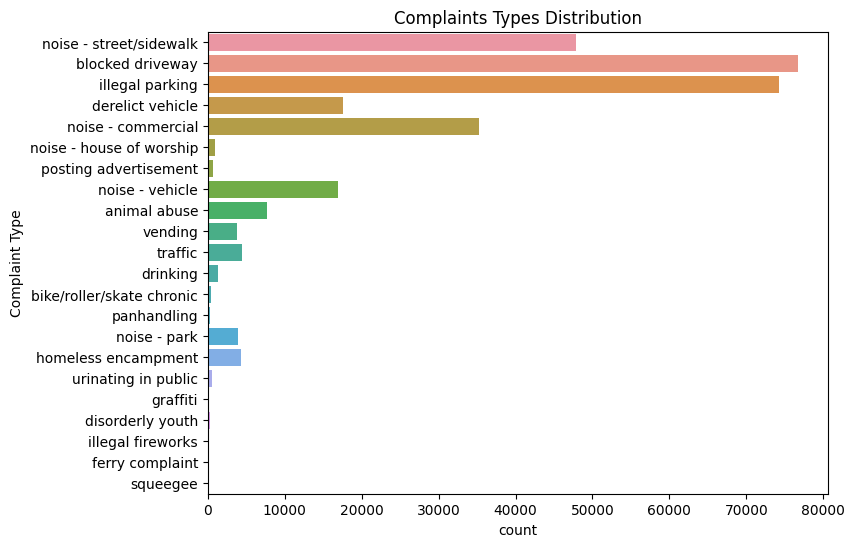

In [15]:
plt.figure(figsize = (8,6))
plt.title('Complaints Types Distribution')
sns.countplot(y ='Complaint Type', data = raw)
plt.show()

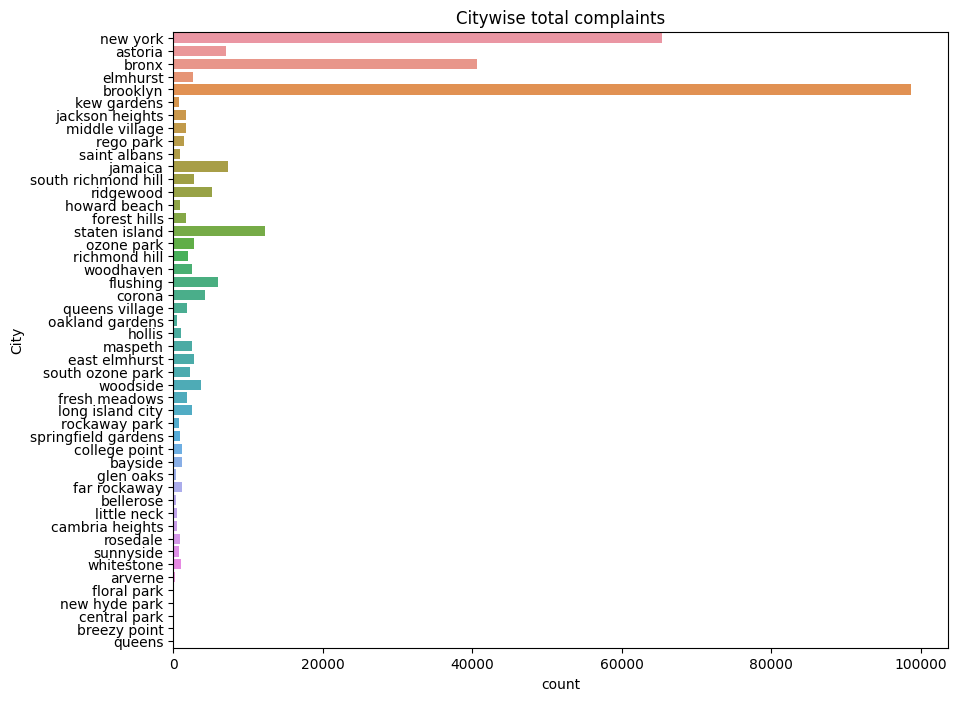

In [18]:
plt.figure(figsize = (10,8))
plt.title('Citywise total complaints')
sns.countplot(y = 'City', data = raw)
plt.show()

In [45]:
top_5_city = raw['City'].value_counts().head(5).index.to_list()
dtop5 = raw[raw.City.isin(top_5_city)]
df1 = pd.crosstab(dtop5['City'], dtop5['Complaint Type'])

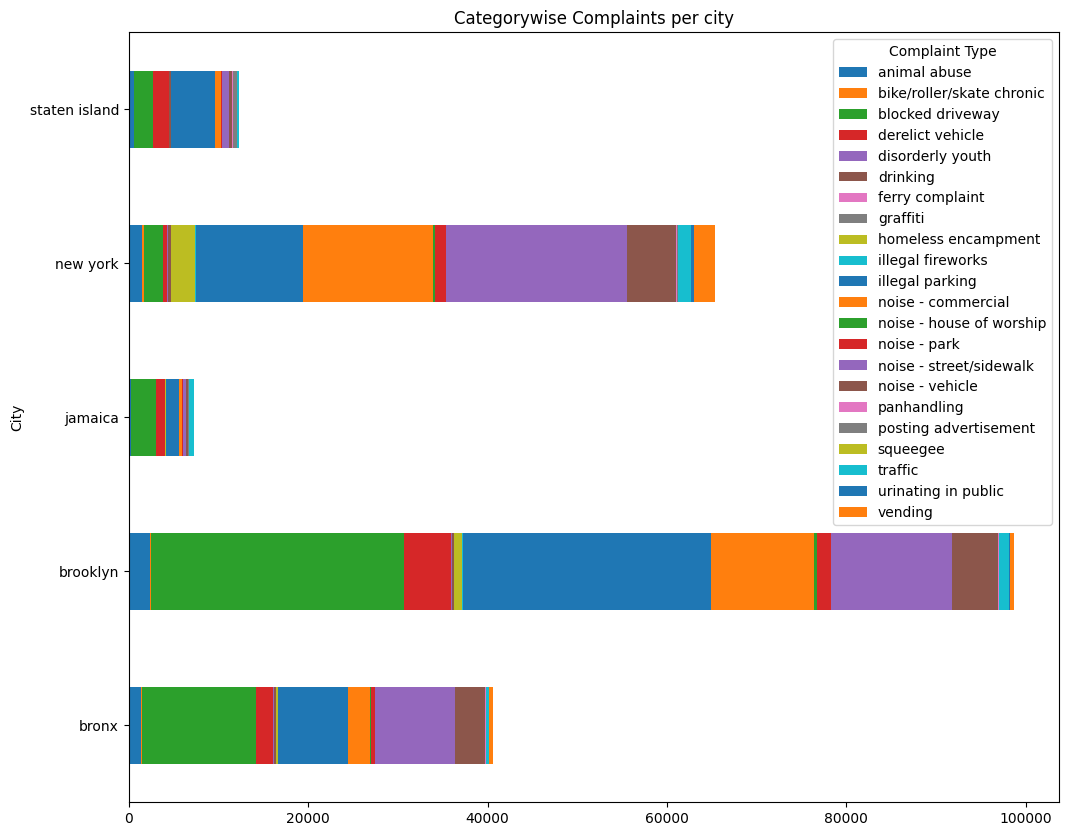

In [47]:
df1.plot(kind='barh',stacked=True,figsize=(12,10))
plt.title('Categorywise Complaints per city')
plt.show()

In [50]:
ComplaintType = raw['Complaint Type'].unique()

In [51]:
len(ComplaintType)

22